In [6]:
data_file="measures_context.csv"
model_name = "clip_unbalanced.pth"

In [7]:
import torch
import clip

# Load CLIP model and the tokenizer
device = "mps"
model, preprocess = clip.load("ViT-B/32")
model = model.to(device)

# Define the fully connected layer
class CLIPWithFC(torch.nn.Module):
    def __init__(self, clip_model, output_dim):
        super(CLIPWithFC, self).__init__()
        self.clip_model = clip_model
        self.fc = torch.nn.Linear(clip_model.visual.output_dim * 2, output_dim) # for concatenated dimensions

    def forward(self, image, text):
        with torch.no_grad():
            # Encode image and text with CLIP
            image_features = self.clip_model.encode_image(image)
            text_features = self.clip_model.encode_text(text)

        # Combine embeddings (here, we're just concatenating as both are in the same embedding space)
        combined_features = torch.cat((image_features, text_features), dim=1)
        
        # print(combined_features.shape)
        # print(self.clip_model.visual.output_dim)
        
        # Pass through the fully connected layer
        scores = self.fc(combined_features)
        return scores

# Create the model instance
output_dim = 1  # Assuming you want a single score as the output
model_with_fc = CLIPWithFC(model, output_dim).to(device)

# Example usage
from PIL import Image

# Prepare input image and text (adapt according to your data)
image_path = './10594-screenshot.jpg'
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
text = clip.tokenize(["Your text description"]).to(device)

# Predict the score
model_with_fc.eval()  # Set the model to evaluation mode
score = model_with_fc(image, text)
print(f'Predicted Score: {score.item()}')

Predicted Score: 0.05691894516348839


In [8]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MeasuresDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, indices=None):
        data = pd.read_csv(csv_file)
        if indices is not None:
            self.data = data.iloc[indices]
        else:
            self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        page = str(int(self.data.iloc[idx]['Page']))
        label = self.data.iloc[idx]['Final Score']
        # text_description = "hi cat" # Adjust to your text column
        text_description = self.data.iloc[idx]['Description']

        img_path = os.path.join(self.image_dir, f"{page}.jpg")
        # image = Image.open(img_path).convert('RGB')
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        # Apply transformations, if provided
        # if self.transform:
        #     image = self.transform(image)
        
        image = image.squeeze(0) if image.dim() == 4 else image
            
        text_description = clip.tokenize([text_description]).to(device)
        
        text_description = text_description.squeeze(0)

        return image, text_description, torch.tensor(label, dtype=torch.float)



# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size expected by the network
    transforms.ToTensor()
])
# Load dataset
dataset = MeasuresDataset(csv_file=data_file, image_dir='./combined', transform=transform)

# Splitting data indices for train and test
total_size = len(dataset) // 2
testsizepercent = 0.2
test_size = int(testsizepercent * total_size)
train_size = total_size - test_size

indices = torch.randperm(total_size).tolist()
train_indices = indices[test_size:]
test_indices = indices[:test_size]

train_dataset = MeasuresDataset(csv_file=data_file, image_dir='./combined', transform=transform, indices=train_indices)
test_dataset = MeasuresDataset(csv_file=data_file, image_dir='./combined', transform=transform, indices=test_indices)

# Create data loaders
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch [1/5], MSE Loss: 0.2353
Epoch [2/5], MSE Loss: 0.0555
Epoch [3/5], MSE Loss: 0.0261
Epoch [4/5], MSE Loss: 0.0174
Epoch [5/5], MSE Loss: 0.0133


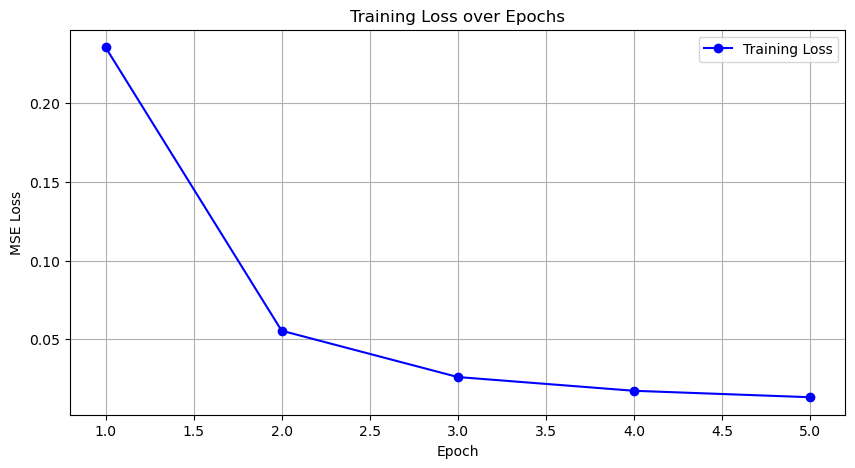

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Prepare model, loss function, and optimizer
device = "mps"
clip_model, preprocess = clip.load("ViT-B/32")
clip_model = clip_model.to(device)
model = CLIPWithFC(clip_model, 1)  # Instantiate the CLIP model wrapper
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

all_epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, texts, labels in dataloader:
        # Move data to GPU if available
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.to(device)
        # print(images.shape, texts.shape)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = model(images, texts)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute and print the average loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    all_epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {avg_loss:.4f}")
    
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), all_epoch_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import numpy as np

def get_category(s):
    if s <= 0.4:
        return "Poor"
    elif 0.4 < s <= 0.6:
        return "Fair"
    elif 0.6 < s <= 1:
        return "Good"

def model_predict_class(image, model, text):
    scores = model(image, text)
    scores = scores.squeeze()
    categories, ss = [], []
    for score in scores:
        s = score.item()
        if s <= 0.4:
            category = "Poor"
        elif 0.4 < s <= 0.6:
            category = "Fair"
        elif 0.6 < s <= 1:
            category = "Good"
        ss.append(s)
        categories.append(category)
    return categories, ss

def create_confusion_matrix(labels, predictions):
    categories = ["Poor", "Fair", "Good"]
    confusion_matrix = np.zeros((len(categories), len(categories)), dtype=int)
    for i in range(len(labels)):
        true_category = labels[i]
        pred_category = predictions[i]
        true_index = categories.index(true_category)
        pred_index = categories.index(pred_category)
        confusion_matrix[true_index][pred_index] += 1
    return confusion_matrix

from tqdm import tqdm

# Initialize lists to store labels and predictions
true_labels = []
predicted_labels = []

# Iterate through test_loader with tqdm for progress tracking
for images, texts,labels in tqdm(test_loader, desc='Processing Images'):
    images, labels = images.to(device), labels.to(device)
    output, scores = model_predict_class(images, model, texts)
    # Append true labels and predicted labels from each batch
    true_labels.extend([get_category(label.item()) for label in labels])
    predicted_labels.extend(output)

# Calculate confusion matrix
conf_matrix = create_confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Processing Images: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

Confusion Matrix:
[[ 2  6  1]
 [16 66 14]
 [ 2 20  7]]


In [15]:
def calculate_f1_scores(conf_matrix):
    num_classes = conf_matrix.shape[0]
    f1_scores = []

    # Calculating precision, recall, and F1 score for each class
    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
        f1_scores.append(f1)

    return f1_scores

calculate_f1_scores(conf_matrix)

[0.13793103448275865, 0.702127659574468, 0.27450980392156865]

In [17]:
from tqdm import tqdm

# Initialize list to store test losses
test_losses = []

# Set the model to evaluation mode
model.eval()

# Iterate through test_loader with tqdm for progress tracking
for images, texts,labels in tqdm(test_loader, desc='Processing Images'):
    images, labels = images.to(device), labels.to(device)
    # Forward pass to get outputs
    outputs = model(images, texts)
    # Calculate loss
    loss = criterion(outputs, labels)
    # Append test loss from each batch
    test_losses.append(loss.item())

# Calculate average test loss
average_test_loss = np.mean(test_losses)

# Print average test loss
print("Average Test Loss:", average_test_loss)

Processing Images:   0%|          | 0/5 [00:00<?, ?it/s]/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Processing Images:  80%|████████  | 4/5 [00:03<00:00,  1.08it/s]/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Processing Images: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

Average Test Loss: 0.02461448349058628
